In [1]:
# pull data statements from Wikidata via ACMI ID.

from IPython.display import Image, display
import json
import pandas
import pydash
import requests

def value_extract(row, column):

    ''' Extract dictionary values. '''
    
    return pydash.get(row[column], 'value')

def sparql_query(query, service):

    ''' Send sparql request, and formulate results into a dataframe. '''

    response = requests.get(service, params={'format': 'json', 'query': query}, timeout=120)
    results = pydash.get(response.json(), 'results.bindings')
    data_frame = pandas.DataFrame.from_dict(results)
    for column in data_frame.columns:
        data_frame[column] = data_frame.apply(value_extract, column=column, axis=1)
    
    return data_frame

# ACMI ID for Jacki Weaver.

acmi_creator_id = '73769'

# Pull Wikidata ID from ACMI -> Wikidata creator link (P7003).

query1 = ''' select ?wikidata_creator_id where { ?wikidata_creator_id wdt:P7003 "creators/'''+acmi_creator_id+'''" } '''
link_query = sparql_query(query1, 'https://query.wikidata.org/sparql')

# If link exists, pull formulated string with basic birth details.

if len(link_query):
    wikidata_link = pydash.get(link_query.to_dict('records'), '0.wikidata_creator_id')
    wikidata_link = wikidata_link.split('/')[-1]

    query2 = ''' 
    select ?creatorLabel ?creator_dob ?creator_pobLabel {
        values ?creator {wd:'''+wikidata_link+'''}
        optional { ?creator wdt:P569 ?creator_dob } .
        optional { ?creator wdt:P19 ?creator_pob } .
        service wikibase:label { bd:serviceParam wikibase:language "en". }
        } '''
    data_query = sparql_query(query2, 'https://query.wikidata.org/sparql')
    data_query = data_query.to_dict('records')[0]

    print(f"{data_query['creatorLabel']} (born {data_query['creator_pobLabel']}, {data_query['creator_dob'][:4]})")

Jacki Weaver (born Sydney, 1947)


In [2]:
# Pull Wikipedia text summary.

# ACMI ID for Jacki Weaver.

acmi_creator_id = '73769'

# Pull Wikidata ID from ACMI -> Wikidata creator link (P7003).

query1 = ''' select ?wikidata_creator_id where { ?wikidata_creator_id wdt:P7003 "creators/'''+acmi_creator_id+'''" } '''
link_query = sparql_query(query1, 'https://query.wikidata.org/sparql')

# If link exists, pull entity summary from Wikipedia API.

if len(link_query):
    wikidata_link = pydash.get(link_query.to_dict('records'), '0.wikidata_creator_id')
    wikidata_link = wikidata_link.split('/')[-1]

    # pull the Wikipedia page title.

    wikipedia_link = requests.get(f'https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=sitelinks&ids={wikidata_link}&sitefilter=enwiki')
    wikipedia_link_dict = json.loads(wikipedia_link.text)
    if pydash.get(wikipedia_link_dict, 'success') == 1:

        # using page reference title to pull extract entity summary.        

        wikipedia_name = pydash.get(wikipedia_link_dict, f'entities.{wikidata_link}.sitelinks.enwiki.title')
        wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{wikipedia_name.replace(' ','_')}")
        wikipedia_query = json.loads(wikipedia_query.text)

        print(wikipedia_query['extract'])

Jacqueline Ruth Weaver is an Australian theatre, film, and television actress. Weaver emerged in the 1970s as a symbol of the Australian New Wave through her work in Ozploitation films such as Stork (1971), Alvin Purple (1973), and Petersen (1974). She later starred in Picnic at Hanging Rock (1975), Caddie (1976), Squizzy Taylor (1982), and a number of made-for-television movies, miniseries, and Australian productions of revered plays such as Death of a Salesman and A Streetcar Named Desire.


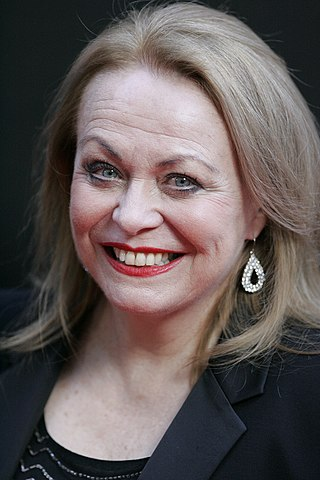

In [3]:
# Pull Wikipedia image.

# ACMI ID for Jacki Weaver.

acmi_creator_id = '73769'

# Pull Wikidata ID from ACMI -> Wikidata creator link (P7003).

query1 = ''' select ?wikidata_creator_id where { ?wikidata_creator_id wdt:P7003 "creators/'''+acmi_creator_id+'''" } '''
link_query = sparql_query(query1, 'https://query.wikidata.org/sparql')

# If link exists, pull image from Wikipedia API.

if len(link_query):
    wikidata_link = pydash.get(link_query.to_dict('records'), '0.wikidata_creator_id')
    wikidata_link = wikidata_link.split('/')[-1]

    # pull the Wikipedia page title.

    wikipedia_link = requests.get(f'https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=sitelinks&ids={wikidata_link}&sitefilter=enwiki')
    wikipedia_link_dict = json.loads(wikipedia_link.text)
    if pydash.get(wikipedia_link_dict, 'success') == 1:

        # using page reference title to pull image.        

        wikipedia_name = pydash.get(wikipedia_link_dict, f'entities.{wikidata_link}.sitelinks.enwiki.title')
        wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{wikipedia_name.replace(' ','_')}")
        wikipedia_query = json.loads(wikipedia_query.text)

        if pydash.get(wikipedia_query, 'thumbnail.source'):
            url = pydash.get(wikipedia_query, 'thumbnail.source').replace(' ','_')
            display(Image(url,width=300, height=300))